<a href="https://colab.research.google.com/github/szelld/monkey_stack_deeplearning/blob/main/Skin_Cancer_Detection_Milestone_1_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have chosen the **ISIC 2024 - Skin Cancer Detection task with 3D-TBP**, and this is our first milestone.
You can find the problem and the dataset we used [here](https://www.kaggle.com/competitions/isic-2024-challenge).
In this milestone, we load the necessary data, convert it to the appropriate format and scale, and set up a data generator, among other steps. Please find detailed explanations and code below.

First we import the necessary libraries

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import pandas as pd
keras = tf.keras

import h5py
import shutil
from PIL import Image
import io
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


First, we uploaded the provided .zip file from Kaggle to Google Drive and downloaded it here to expedite the workflow. We unzip the file in the Google Colab environment because it is significantly faster than on our own setup. This code block is simply a representation of our workflow; **there’s no need to run it**. We process the data and organize it into different folders, then zip it within the environment. Later, you’ll find a code block that allows you to download the processed and organized data.
These zipping and parsing codeblock are very timconsuming to run, so we advise you to only download the organized zip later.

In [ ]:
# Install gdown if you haven't already
!pip install gdown

# File ID
file_id = '17ezz6Onjpe48XvPrBcYHhZaJ8kAvRSG3'
download_link = f'https://drive.google.com/uc?id={file_id}'

# Download the ZIP file
!gdown --id {file_id} --output dataset.zip

# Unzip the downloaded file
!unzip dataset.zip -d /content/dataset

In this section, we organize the data based on the isic_id provided in the hdf5 file. It is needed to later load in the images using the ImageDataGenerator function from keras. You don't need to run this code, we saved the organized data as a zip file (see the section under this one), and you can get that file running the marked code.

In [ ]:
# Define paths and parameters
hdf5_file_path = 'dataset/train-image.hdf5'  # Path to your HDF5 file
metadata_file_path = 'dataset/train-metadata.csv'  # Path to your metadata CSV
image_folder = 'images'  # Base folder for images
folder1_name = 'benign'  # Name of folder for images with target value 0
folder2_name = 'malignant'  # Name of folder for images with target value 1
target_column = 'target'  # Column in metadata containing the target value

# Create folders if they don't exist
os.makedirs(os.path.join(image_folder, folder1_name), exist_ok=True)
os.makedirs(os.path.join(image_folder, folder2_name), exist_ok=True)

# Open HDF5 file
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    # Read metadata
    import pandas as pd
    metadata_df = pd.read_csv(metadata_file_path)

    # Iterate through metadata
    for index, row in metadata_df.iterrows():
        isic_id = row['isic_id']
        target_value = row[target_column]

        # Get image data from HDF5
        image_data = hdf5_file[isic_id][()]

        # Convert to PIL Image
        image = Image.open(io.BytesIO(image_data))

        # Determine destination folder
        destination_folder = folder1_name if target_value == 0 else folder2_name

        # Save image to destination folder
        image_path = os.path.join(image_folder, destination_folder, f"{isic_id}.jpg")
        image.save(image_path)

        print(f"Saved image {isic_id} to {destination_folder}")

print("Image separation complete!")

In [ ]:
# Define paths
image_folder = 'images'  # Path to the images folder
zip_file_name = 'images.zip'  # Name of the zip file

# Create zip file
shutil.make_archive(zip_file_name[:-4], 'zip', image_folder)

print(f"Zip file '{zip_file_name}' created successfully.")

### YOU NEED TO RUN THIS TO GET THE DATA

The code block below will assist you in downloading the zip file that contains the organized data. This code will unzip the file, which may take some time, and will create two folders: one named "benign," which contains images of non-cancerous moles, and the other named "malignant," which contains images of cancerous moles.

In [ ]:
# Install gdown if you haven't already
!pip install gdown

# File ID from the provided link
file_id = '1UlGjhWlDpL9nIT0CdyJGnMxCJc5VZuCx'
download_link = f'https://drive.google.com/uc?id={file_id}'

# Download the ZIP file
!gdown --id {file_id} --output dataset.zip

# Create a folder for the organized dataset
!mkdir Organized_Dataset

# Unzip the downloaded file into the Organized_Dataset folder
!unzip dataset.zip -d Organized_Dataset

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: Organized_Dataset/benign/ISIC_1399219.jpg  
  inflating: Organized_Dataset/benign/ISIC_0632500.jpg  
  inflating: Organized_Dataset/benign/ISIC_2725785.jpg  
  inflating: Organized_Dataset/benign/ISIC_7632164.jpg  
  inflating: Organized_Dataset/benign/ISIC_6491430.jpg  
  inflating: Organized_Dataset/benign/ISIC_5811800.jpg  
  inflating: Organized_Dataset/benign/ISIC_7078164.jpg  
  inflating: Organized_Dataset/benign/ISIC_5460061.jpg  
  inflating: Organized_Dataset/benign/ISIC_8336137.jpg  
  inflating: Organized_Dataset/benign/ISIC_6265352.jpg  
  inflating: Organized_Dataset/benign/ISIC_7430767.jpg  
  inflating: Organized_Dataset/benign/ISIC_7746968.jpg  
  inflating: Organized_Dataset/benign/ISIC_7739668.jpg  
  inflating: Organized_Dataset/benign/ISIC_2178954.jpg  
  inflating: Organized_Dataset/benign/ISIC_0172797.jpg  
  inflating: Organized_Dataset/benign/ISIC_6941272.jpg  
  inflating: Organized_Dataset/benign

The code below selects 10% of the images from each dataset category and moves them into new directories labeled with "_test." This step is essential for creating a dedicated test dataset, ensuring these images are separated from the original folders for more effective model evaluation.


In [ ]:
def move_percentage_of_files(src_folder, dest_folder, percentage=0.1):
    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Get all files in the source directory
    files = os.listdir(src_folder)
    files = [f for f in files if os.path.isfile(os.path.join(src_folder, f))]

    # Calculate number of files to move
    num_files_to_move = int(len(files) * percentage)

    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    # Move files
    for file_name in files_to_move:
        src_path = os.path.join(src_folder, file_name)
        dest_path = os.path.join(dest_folder, file_name)
        shutil.move(src_path, dest_path)
    print(f"Moved {num_files_to_move} files from {src_folder} to {dest_folder}.")

# Paths
benign_folder = 'Organized_Dataset/benign'
benign_test_folder = 'Test/benign_test'
malignant_folder = 'Organized_Dataset/malignant'
malignant_test_folder = 'Test/malignant_test'

# Move 10% of the images
move_percentage_of_files(benign_folder, benign_test_folder, percentage=0.1)
move_percentage_of_files(malignant_folder, malignant_test_folder, percentage=0.1)


Moved 36060 files from Organized_Dataset/benign to Test/benign_test.
Moved 35 files from Organized_Dataset/malignant to Test/malignant_test.


Here we load in the data to the model using the ImageDataGenerator function from tensorflow-keras. We also rescaled the data, and made an 80% split to train the model, and a 20% split for validation. We do not create test dataset here, because we have already moved images into "test" folders previously.

In [ ]:
# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

data_dir = '/content/Organized_Dataset'

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 259888 images belonging to 2 classes.
Found 64971 images belonging to 2 classes.


Some visualization for the images.

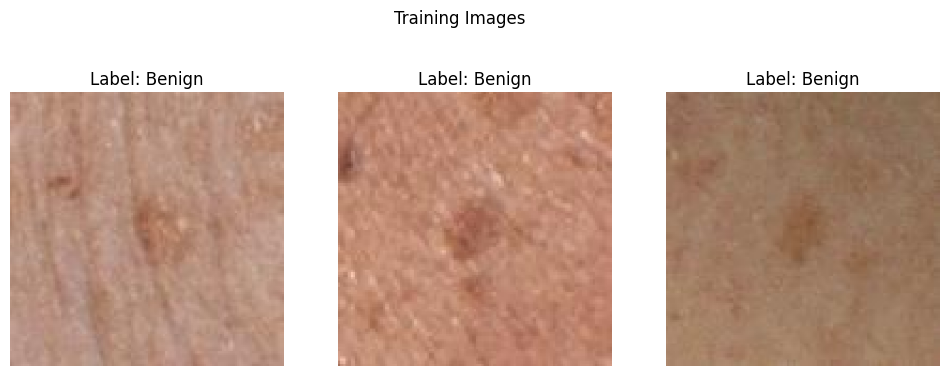

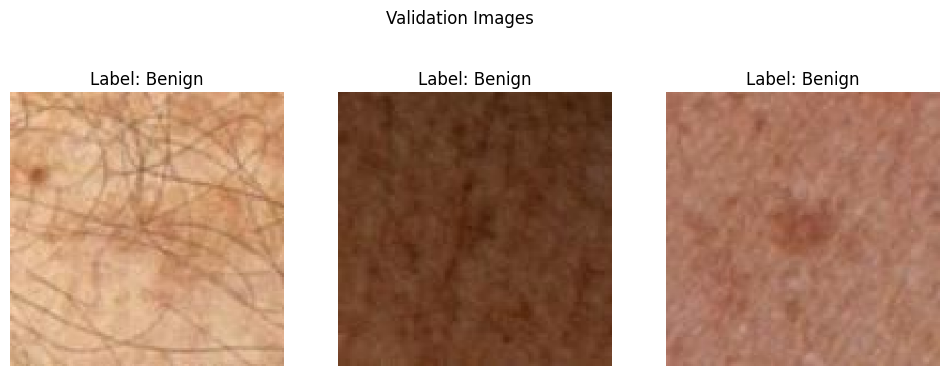

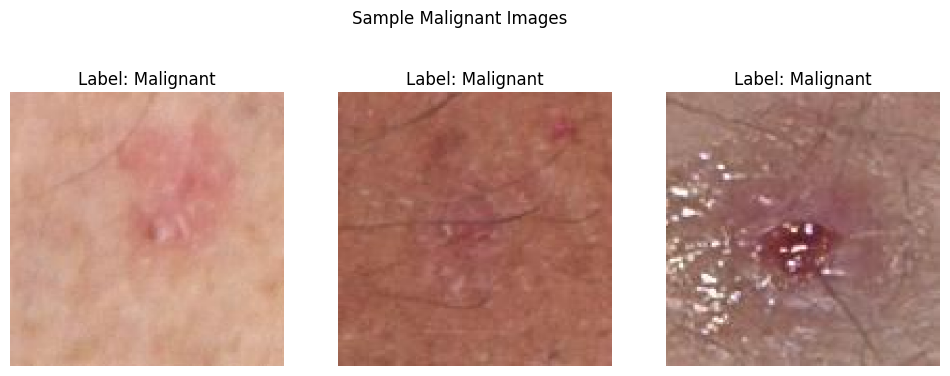

In [ ]:
# Fetch a single batch of training data
X_train_batch, y_train_batch = next(train_generator)  # Gets the next batch of training data

# Fetch a single batch of validation data
X_val_batch, y_val_batch = next(validation_generator)  # Gets the next batch of validation data

# Function to visualize images
def plot_images(images, labels, title):
    plt.figure(figsize=(12, 8))
    for i in range(3):  # Display 6 images
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {"Malignant" if labels[i] == 1 else "Benign"}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize a batch of training images
plot_images(X_train_batch, y_train_batch, "Training Images")

# Visualize a batch of validation images
plot_images(X_val_batch, y_val_batch, "Validation Images")

# Load and visualize images directly from the "Organized_Dataset/malignant" folder
def plot_malignant_images_from_folder(folder_path, num_images=6):
    images = []
    file_names = os.listdir(folder_path)
    sample_files = file_names[:num_images]  # Select a few images from the folder

    for file_name in sample_files:
        img_path = os.path.join(folder_path, file_name)
        img = load_img(img_path, target_size=(256, 256))  # Load image and resize if necessary
        img_array = img_to_array(img) / 255.0  # Normalize to match the other images
        images.append(img_array)

    # Display the malignant images
    plot_images(images, [1]*num_images, "Sample Malignant Images")

# Path to the malignant folder
malignant_folder = 'Organized_Dataset/malignant'
plot_malignant_images_from_folder(malignant_folder)
